# Formation and refinement of cells during plastic deformation
This is a notebook made for the data analysis presented in the paper "Formation and refinement of cells during plastic deformation" by Zelenika et al. It aims to provide an overview to the reader of the necessary data analysis and the underlying logic used to produces the results and plots shown in the article. This notebook follows the layout seen in the supplimentary materials of the paper. 

The various cells should provide the reader with the ability to remake all the figures shown in the paper as well as potentially manipulate the data. This Notebook has the goal of bringing these large datasets and the resulting data analysis to a large audience of material scientists and physicist who may not be used to working with the rich datasets produced by synchrotron experiments. It is the hope of the authors that this endeavour will lead to increased interest, trust and data analysis pipelines for Dark-Field X-ray Microscopy studies. 

# Import all the necessary packages 
This note book should be run in an adequate kernel with the necessary dependencies. The git repository hosting this notebook contains such a kernel titled "matlab" as part of this code is a direct translation of a legacy matlab scripts written by Henning Friis Poulsen. 

In [1]:
from DFXM.scan_functions import *
from DFXM.image_processor import inv_polefigure_colors 

# Import the data 

Load the DFXM images needed for the analysis and define the necessary system constants such as pixel size and strain levels.

In this step the files are also sorted by strain level to ensure a match with the strain list that is a user input.

All necessary global lists should also be defined here. 

In [2]:
path = 'C:\\Users\\adacre\\OneDrive - Danmarks Tekniske Universitet\\Documents\\DTU_Project\\data\\fit15\\'
pixel_y = 0.203; pixel_x = 0.6575; # effective pixel sizes in mu

com_phi, com_chi = load_data(path, 'com')
fwhm_phi, fwhm_chi = load_data(path, 'fwhm')

strain = [0, 0.005, 0.008, 0.013, 0.024, 0.035, 0.046, 0.046, 0.046, 0.046]

com_phi = sorted(com_phi, key=extract_number)
com_chi = sorted(com_chi, key=extract_number)
fwhm_phi = sorted(fwhm_phi, key=extract_number)
fwhm_chi = sorted(fwhm_chi, key=extract_number)

v_fraction, mean_grain, av_neighbours, av_misorientaion, GNDs, ave_GNDs = [], [], [], [], [], []
i = 0

# Figure 1

The next section creates a mosaicity map of the sample that has been deformed to 4.6%. It shows on overlay of the cells, defined by a Kernal Average Misorientation (KAM) calculated from the Center of Mass of each pixel (COM) mask, on the Full Width Half Max (FWHM) information of the scan. 

In [3]:
# load the COM images
Img_chi, maximum_chi, minimum_chi, average_chi, TF_chi, row_size_chi, col_size_chi, _ = process_data(path, com_chi[7], method='COM')
Img_phi, maximum_phi, minimum_phi, _, _, _, _, _ = process_data(path, com_phi[7], method='COM')

# Define the colour grid for the mosaicity map
test_grid = np.array((np.linspace(minimum_chi, maximum_chi, 25), np.linspace(minimum_phi, maximum_phi, 22)), dtype=object)
o_grid = np.array((np.linspace(minimum_chi, maximum_chi, 500), np.linspace(minimum_phi, maximum_phi, 500)), dtype=object)
colours, colour_data = inv_polefigure_colors(o_grid, test_grid)

# Create the mosaicity map
grain = find_grain(TF_chi)
_, _, grain_mask = values_histogram(Img_chi, maximum_chi, grain)

Img_chi = filter_grain(grain_mask, Img_chi, maximum_chi)
Img_phi = filter_grain(grain_mask, Img_phi, maximum_phi)

scaled_Img_chi = scale_image(Img_chi)
scaled_Img_phi = scale_image(Img_phi)

mosa, Mosa_Img = RGB_image(scaled_Img_chi, scaled_Img_phi)

# KAM calculation

Compute the KAM for the selected image and create the KAM skeleton

In [4]:
KAM = calculate_KAM(col_size_chi, row_size_chi, grain_mask, Img_chi, Img_phi, 2)

KAM_mask, skel_KAM = KAM_refine(KAM, grain_mask)

(1830, 1569)
KAM mask: percentage in walls 99.40% with KAM threshold: 0.005
KAM mask: percentage in walls 98.78% with KAM threshold: 0.006
KAM mask: percentage in walls 97.91% with KAM threshold: 0.007
KAM mask: percentage in walls 96.83% with KAM threshold: 0.008
KAM mask: percentage in walls 95.61% with KAM threshold: 0.009000000000000001
KAM mask: percentage in walls 94.27% with KAM threshold: 0.01
KAM mask: percentage in walls 92.91% with KAM threshold: 0.011
KAM mask: percentage in walls 91.55% with KAM threshold: 0.012
KAM mask: percentage in walls 90.22% with KAM threshold: 0.013000000000000001
KAM mask: percentage in walls 88.95% with KAM threshold: 0.014000000000000002
KAM mask: percentage in walls 87.74% with KAM threshold: 0.015
KAM mask: percentage in walls 86.54% with KAM threshold: 0.016
KAM mask: percentage in walls 85.41% with KAM threshold: 0.017
KAM mask: percentage in walls 84.34% with KAM threshold: 0.018000000000000002
KAM mask: percentage in walls 83.30% with KAM 

# Plotting the mosaicity map

Here the mosaicity map and a zoomed in area of this map is plotted using the colour convention defined above.

In [5]:
# New extent limits for x-axis
x_min_new = 260
x_max_new = 790

# Remove the NaN pixels
Mosa_Img[~grain_mask] = [1, 1, 1]

# Total extent along the x-axis
total_extent_x = pixel_x * row_size_chi

# Image dimensions
_, image_width, _ = Mosa_Img.shape

# Calculate new pixel indices for cropping on x-axis
left = int((x_min_new / total_extent_x) * image_width)
right = int((x_max_new / total_extent_x) * image_width)

# Since y-axis remains unchanged, use full height
top = 0
bottom = Mosa_Img.shape[0]

Mosa_Img = Mosa_Img[top:bottom, left:right]

# Calculate the center of the image
center_y, center_x = Mosa_Img.shape[0] // 2, Mosa_Img.shape[1] // 2

# Define the region of interest (ROI) dimensions
roi_size_x = 150  
roi_size_y = 200
half_roi_size_x = roi_size_x // 2
half_roi_size_y = roi_size_y // 2

scale_bar_physical_length = 10  # e.g., 50 μm

# Calculate the scale bar length in pixels for the main image
scale_bar_pixel_length_main = scale_bar_physical_length / pixel_x

# Calculate ROI coordinates
roi_start_x = max(center_x - half_roi_size_x+45, 0)
roi_end_x = min(center_x + half_roi_size_x+45, Mosa_Img.shape[1])
roi_start_y = max(center_y - half_roi_size_y+100, 0)
roi_end_y = min(center_y + half_roi_size_y+100, Mosa_Img.shape[0])

# Calculate the scale bar length in pixels for the zoomed image
# First, find out how many pixels per micrometer in the zoomed region
zoom_factor_x = roi_size_x / (roi_end_x - roi_start_x)
zoom_factor_y = roi_size_y / (roi_end_y - roi_start_y)
pixels_per_micrometer_zoomed_x = zoom_factor_x / pixel_x
pixels_per_micrometer_zoomed_y = zoom_factor_y / pixel_y
scale_bar_pixel_length_zoomed = scale_bar_physical_length * pixels_per_micrometer_zoomed_x

# Scaling factor for the x-axis
scale_x = (x_max_new - x_min_new) / Mosa_Img.shape[1]
# Scaling factor for the y-axis
scale_y = (pixel_y * col_size_chi) / Mosa_Img.shape[0]

# Apply scaling to ROI coordinates
roi_start_x_scaled = roi_start_x * scale_x + x_min_new
roi_start_y_scaled = roi_start_y * scale_y

# Adjust ROI size if necessary based on the extent
roi_size_scaled_x = roi_size_x * scale_x
roi_size_scaled_y = roi_size_y * scale_y


# Extract the region of interest for the zoomed figure
zoomed_region = Mosa_Img[roi_start_y:roi_end_y, roi_start_x:roi_end_x]

total_height = pixel_y * col_size_chi
adjusted_roi_start_y_scaled = total_height - roi_start_y_scaled - roi_size_scaled_y


Plotting

# Peak broadening analysis

In this section the Full Width Half Maximum (FWHM) data is extracted and plotted in the same way as the mosaicity map with the overlaid KAM skeleton to highlight the presence of cells.

In [6]:
#Load the FWHM data

FWHM_chi, maximum_chi, minimum_chi, _, _, _, _, _ = process_data(path, fwhm_chi[7], method='FWHM', grain_mask=grain_mask)
FWHM_phi, maximum_phi, minimum_phi, _, _, _, _, _ = process_data(path, fwhm_phi[7], method='FWHM', grain_mask=grain_mask)

# Combine the Phi and Chi contributions to the FWHM
#FWHM_img = np.sqrt(FWHM_chi**2 + FWHM_phi**2) 
FWHM_img = FWHM_chi + FWHM_phi
FWHM_img[FWHM_img > 4] = 4




The information is treated and the ROI is defined. To highlight the presence of dislocation pileup at the cell boundaries, the KAM skeleton is ovelerlay on the FWHM map.   

An overview of the FWHM information is also plotted here.

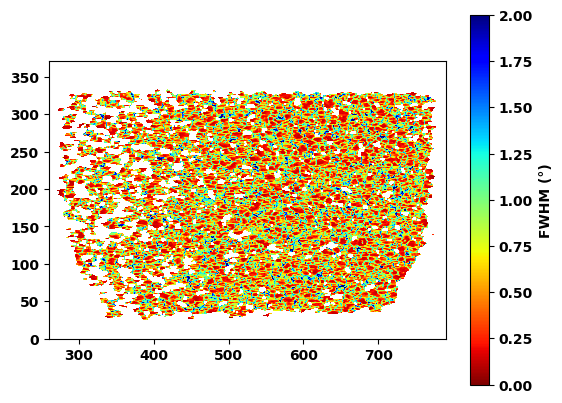

In [7]:
FWHM_img = np.where(skel_KAM, 2.5, FWHM_img)
FWHM_img = FWHM_img[top:bottom, left:right]


zoomed_region_fwhm = FWHM_img[roi_start_y:roi_end_y, roi_start_x:roi_end_x]

plt.imshow(FWHM_img, cmap='jet_r', extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi], vmin=0, vmax=2)
plt.colorbar(label='FWHM (°)')

# Plotting the figure 

This next section deals with plottin part of Figure 1 of the publication. This publication can be founds at:.   

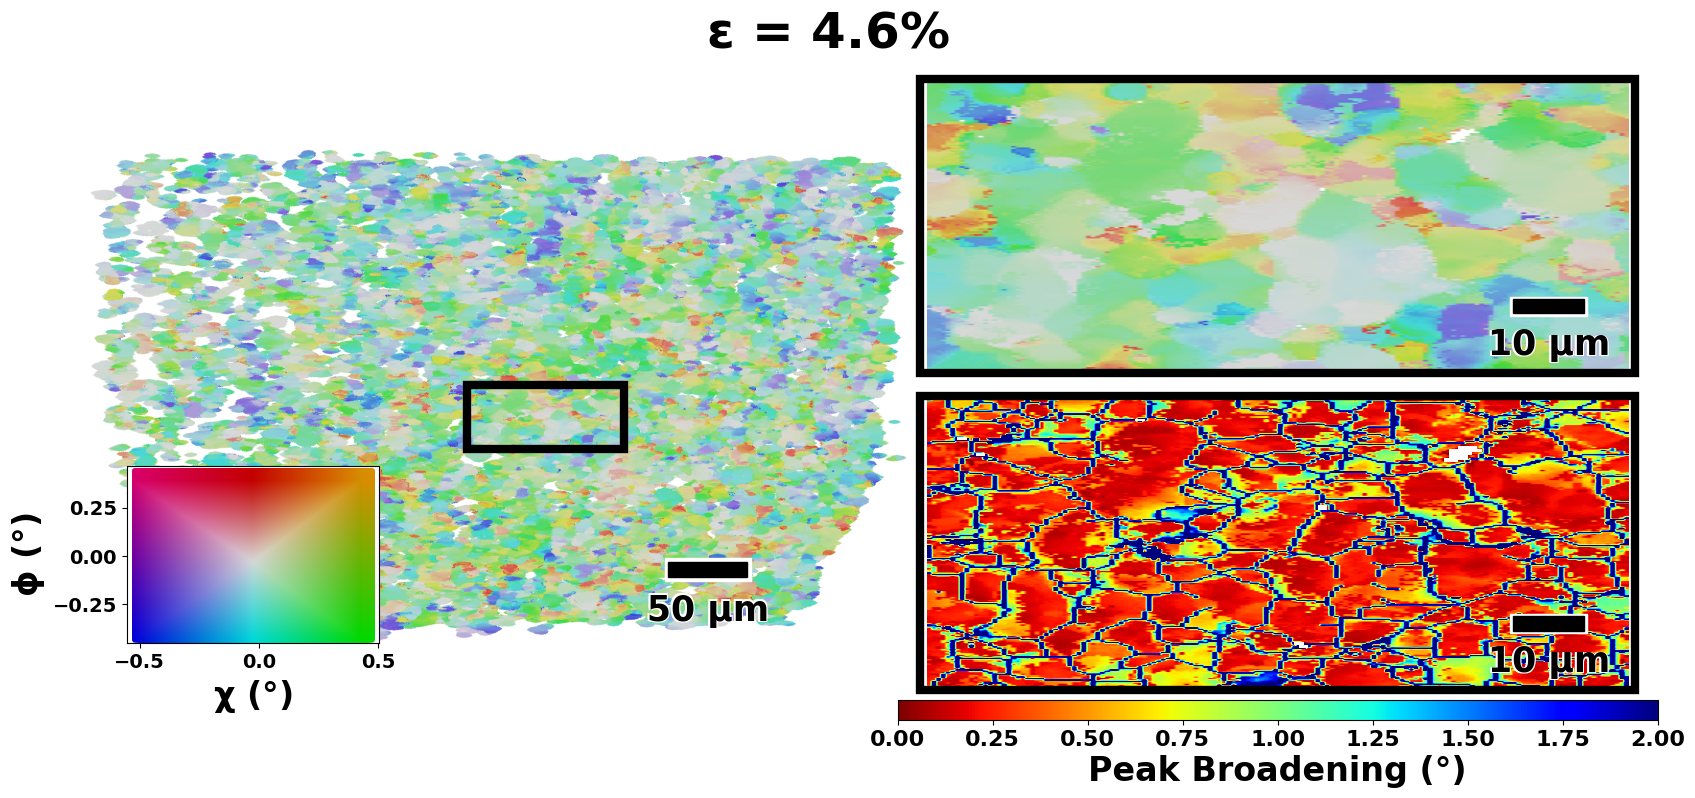

In [14]:
scale_bar_length = 50
scale_bar_thickness = 10
x_position = x_max_new * 0.8
y_position = pixel_y * col_size_chi * 0.2
aspect_ratio = pixel_y / pixel_x


# Initialize figure and GridSpec
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1.2, 1])
# Axes for the original image
ax0 = fig.add_subplot(gs[:, 0]) 
ax0.imshow(Mosa_Img, extent=[x_min_new, x_max_new, 0, pixel_y * col_size_chi])

# Rectangle for the ROI
roi_rect = patches.Rectangle((roi_start_x_scaled, adjusted_roi_start_y_scaled), roi_size_scaled_x, roi_size_scaled_y, linewidth=6, edgecolor='black', facecolor='none')
ax0.add_patch(roi_rect)

# Scale bar and its shadow
rect_shadow = patches.Rectangle((x_position - 2, y_position + 2), scale_bar_length + 4, -(scale_bar_thickness + 4), linewidth=1, edgecolor='white', facecolor='white')
ax0.add_patch(rect_shadow)
rect_scale = patches.Rectangle((x_position, y_position), scale_bar_length, -scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax0.add_patch(rect_scale)

# Text and shadow
for dx, dy in [(-1, 1), (1, 1), (1, -1), (-1, -1)]:
    ax0.text(x_position + scale_bar_length / 2 + dx, y_position - scale_bar_thickness * 2 + dy, '50 μm', color='white', ha='center', va='top', fontsize=25, fontweight='bold')
ax0.text(x_position + scale_bar_length / 2, y_position - scale_bar_thickness * 2, '50 μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')
ax0.axis('off')

# Inset axis for the scatter plot
inset_ax = inset_axes(ax0, width="30%", height="30%", loc='lower left', bbox_to_anchor=(0.05, 0.05, 1, 1), bbox_transform=ax0.transAxes)
inset_ax.scatter(colour_data.T[0], colour_data.T[1], c=colours, s=65, marker=',')
inset_ax.set_xlabel('$\chi$ (°)', fontsize=24)
inset_ax.set_ylabel('$\phi$ (°)', fontsize=24)
inset_ax.axis('on')
inset_ax.tick_params(labelsize=14)

# Axes for the zoomed region (assumed to be the second plot)
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(zoomed_region, aspect=aspect_ratio)
frame = patches.Rectangle((-0.01, -0.01), 1.02, 1.02, transform=ax1.transAxes, linewidth=6, edgecolor='black', facecolor='none', clip_on=False)
ax1.add_patch(frame)

# Scale bar position and dimensions for the zoomed region
scale_bar_position_zoomed = (zoomed_region.shape[1] - 25, zoomed_region.shape[0] - 50)
rect_shadow_zoomed = patches.Rectangle((scale_bar_position_zoomed[0] - (2 * aspect_ratio), scale_bar_position_zoomed[1] + 11.5), scale_bar_pixel_length_zoomed + 4 * aspect_ratio, -(scale_bar_thickness + 4 * aspect_ratio + 2), linewidth=1, edgecolor='white', facecolor='white')
ax1.add_patch(rect_shadow_zoomed)
rect_scale_zoomed = patches.Rectangle(scale_bar_position_zoomed, scale_bar_pixel_length_zoomed, scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax1.add_patch(rect_scale_zoomed)

# Adding text shadow or outline effect for scale bar label
for dx, dy in [(-1, 1), (1, 1), (1, -1), (-1, -1)]:  # Offset positions for the shadow
    ax1.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2 + (dx * aspect_ratio), scale_bar_position_zoomed[1] + scale_bar_thickness * 2 + dy * aspect_ratio, f'{scale_bar_physical_length} μm', color='white', ha='center', va='top', fontsize=25, fontweight='bold')
    
# Adding label for the scale bar on the zoomed image
ax1.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2, scale_bar_position_zoomed[1] + scale_bar_thickness * 2, f'{scale_bar_physical_length} μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')

ax1.axis('off')

# Axes for the FWHM zoomed region (assumed to be the third plot)
ax2 = fig.add_subplot(gs[1, 1])
im = ax2.imshow(zoomed_region_fwhm, cmap='jet_r', aspect=aspect_ratio, vmin=0, vmax=2)
frame_fwhm = patches.Rectangle((-0.01, -0.01), 1.02, 1.02, transform=ax2.transAxes, linewidth=6, edgecolor='black', facecolor='none', clip_on=False)
ax2.add_patch(frame_fwhm)

# Add shadow and scale bar for the zoomed FWHM image
rect_shadow_zoomed_fwhm = patches.Rectangle((scale_bar_position_zoomed[0] - (2 * aspect_ratio), scale_bar_position_zoomed[1] + 11.5), scale_bar_pixel_length_zoomed + 4 * aspect_ratio, -(scale_bar_thickness + 4 * aspect_ratio + 2), linewidth=1, edgecolor='white', facecolor='white')
ax2.add_patch(rect_shadow_zoomed_fwhm)
rect_scale_zoomed_fwhm = patches.Rectangle(scale_bar_position_zoomed, scale_bar_pixel_length_zoomed, scale_bar_thickness, linewidth=1, edgecolor='black', facecolor='black')
ax2.add_patch(rect_scale_zoomed_fwhm)

# Add text shadow or outline effect for the scale bar label on the FWHM image
for dx, dy in [(-1, 1), (1, 1), (1, -1), (-1, -1)]:  # Offset positions for the shadow
    ax2.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2 + (dx * aspect_ratio), scale_bar_position_zoomed[1] + scale_bar_thickness * 2 + dy * aspect_ratio, f'{scale_bar_physical_length} μm', color='white', ha='center', va='top', fontsize=25, fontweight='bold')

# Add label for the scale bar on the FWHM image
ax2.text(scale_bar_position_zoomed[0] + scale_bar_pixel_length_zoomed / 2, scale_bar_position_zoomed[1] + scale_bar_thickness * 2, f'{scale_bar_physical_length} μm', color='black', ha='center', va='top', fontsize=25, fontweight='bold')

ax2.axis('off')

# Colorbar for the FWHM image
colorbar_ax = fig.add_axes([0.535, 0.16, 0.38, 0.02])
plt.colorbar(im, cax=colorbar_ax, orientation='horizontal', label='Peak Broadening (°)')
colorbar_ax.set_xlabel('Peak Broadening (°)', fontsize=24)
colorbar_ax.tick_params(labelsize=16)

# Adjust layout and add title
plt.subplots_adjust(wspace=0.01, hspace=-0.3)
plt.suptitle('$\epsilon$ = 4.6%', fontsize=36, fontweight='bold', y=0.87)

plt.show()

# Figure 2

This figure shows how the aspect of the peak broadening at low deformations and aims to perform an analysis of the cluser sizes that are equated to dislocation buildup and the begining of cell formation. 